(589, 48, 96)
(8760, 48, 96)
(1460, 48, 96)
the smallest length is 589
shape (589,)
first instance of analysis_rmse_2 (589,)
            0
0    0.001900
1    0.001746
2    0.001695
3    0.001609
4    0.001532
..        ...
584  0.001546
585  0.001535
586  0.001522
587  0.001497
588  0.001525

[589 rows x 1 columns]
average rmse Hybrid 0.0013778204460888578
average rmse SPEEDY 0.001533824822583902


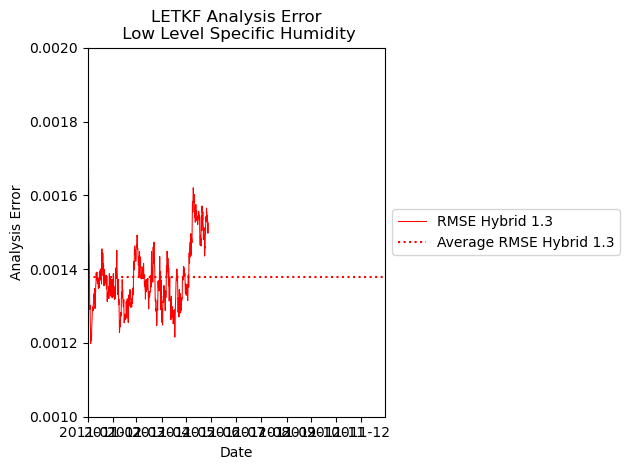

In [9]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit
import pandas as pd

@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0

    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))

    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true

    weights = np.cos(np.deg2rad(lats))

    weights2d = np.zeros(np.shape(diff))

    diff_squared = diff**2.0
    #weights = np.ones((10,96))

    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)

    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)

    return np.sqrt(weighted_average)

start_year = 2011

startdate = datetime(2011,1,1,0)
enddate = datetime(2011,5,28,0)

nature_file = f'/skydata2/troyarcomano/ERA_5/{start_year}/era_5_y{start_year}_regridded_mpi_fixed_var.nc'

#analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_20member_speedy_jan1_dec31_2011.nc'
analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_2011_01_to_2012_05.nc'
#'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_2012_01_to_2012_09.nc'

#analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_20member_hybrid_jan1_dec31_2011.nc'
analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/new_hybrid_analysis_covar_1_3_20110101_20111231/mean.nc'
#'/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_mean.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc' #'~/stable_run/rtpp_0_3.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc'
spread_file =  '/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_sprd.nc' #'/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc' #'~/stable_run/rtpp_0_3.nc' # '/skydata2/troyarcomano/letkf-hybrid-speedy/DATA/ensemble/anal/mean/test.nc'

ds_nature = xr.open_dataset(nature_file)
ds_analysis_mean = xr.open_dataset(analysis_file)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)
ds_spread = xr.open_dataset(spread_file)

lats = ds_nature.Lat

level = 0.95 #0.2#0.95#0.51
level_era = 7 #2#7 #4

time_slice = slice(startdate,enddate)

var_era = 'Specific_Humidity'#'Temperature' #'V-wind'
var_da =  'q'#'t'#'q'
temp_500_nature = ds_nature[var_era].sel(Sigma_Level=level_era).values
temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
temp_500_spread = ds_spread[var_da].sel(lev=level).values                                                                                                                          

print(np.shape(temp_500_analysis_speedy))
print(np.shape(temp_500_nature))
print(np.shape(temp_500_analysis))

#find smallest index value to set that as the "length"
speedy_index = temp_500_analysis_speedy.shape[0]
nature_index = temp_500_nature.shape[0]
hybrid_index = temp_500_analysis.shape[0]
smallest_index = min(speedy_index,nature_index,hybrid_index)
if smallest_index == speedy_index:
    length = speedy_index
elif smallest_index == nature_index:
    length = nature_index
else:
    length = hybrid_index - 1
print('the smallest length is',length)

ps_nature = ds_nature['logp'].values
ps_nature = 1000.0 * np.exp(ps_nature)
ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48
#length = hybrid_index_length#240  #1450 ##338 #160#64#177#1400#455

analysis_rmse_2 = np.zeros((length))
analysis_rmse_speedy_2 = np.zeros((length))
global_average_ensemble_spread= np.zeros((length))
ps_rmse = np.zeros((length))

analysis_error_2 = np.zeros((length,ygrid,xgrid))
analysis_error_speedy_2 = np.zeros((length,ygrid,xgrid))

for i in range(length):
    analysis_rmse_2[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy_2[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis_speedy[i,:,:],lats)
    ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error_2[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i*6,:,:]
    analysis_error_speedy_2[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i*6,:,:]
    #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])

''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''

averaged_error_2 = np.average(abs(analysis_error_2[24::,:,:]),axis=0)
averaged_error_speedy_2 = np.average(abs(analysis_error_speedy_2[24::,:,:]),axis=0)

lat = ds_analysis_mean.lat.values
lon = ds_analysis_mean.lon.values

lons2d, lats2d = np.meshgrid(lon,lat)
#
#
#
#
# interpolate to weekly averages to clean up noise

# try daily first
#print('print speedy data:',temp_500_analysis_speedy)
print('shape',np.shape(analysis_rmse_2))
print('first instance of analysis_rmse_2',np.shape(analysis_rmse_2[::]))
# try with pandas
base = datetime(2011,1,1,0)
date_list = [base + timedelta(days=x/4) for x in range(length)]

speedy_df = pd.DataFrame(analysis_rmse_2[::])
print(speedy_df)

#averages = [np.mean(analysis_rmse_2[i:i+7]) for i in range(7)]
#print(len(averages))
#print(np.shape(averages))


'''plot'''
base = datetime(2011,1,1,0)
# plot
#length = 481 
date_list = [base + timedelta(days=x/4) for x in range(length)]
#'''2'''
#length = 481 


plt.plot(date_list,analysis_rmse_2,color='r',linewidth=.75,label='RMSE Hybrid 1.3') #cov-infl1.3
plt.axhline(y=np.average(analysis_rmse_2[20:-1:]), color='r', linestyle=':',label="Average RMSE Hybrid 1.3")
#plt.plot(date_list,analysis_rmse_speedy_2,color='b',linewidth=.75,label='RMSE SPEEDY 1.3')
#plt.axhline(y=np.average(analysis_rmse_speedy_2[20::]), color='b', linestyle='--',label="Average RMSE SPEEDY 1.3")

print('average rmse Hybrid', np.average(analysis_rmse_2[20::]))
print('average rmse SPEEDY', np.average(analysis_rmse_speedy_2[20::]))
plt.title('LETKF Analysis Error\n Low Level Specific Humidity')
plt.legend(loc='center left',fontsize=10, bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Analysis Error')
#plt.ylabel('Analysis Error (kg/kg)')
#plt.ylabel('Ensemble Spread (K)')
# plt.xticks(date_list[::305])
plt.xlim([datetime(2011, 1, 1,0), datetime(2011, 12, 31,0)])
plt.ylim(0.001,0.002)
plt.tight_layout()
#plt.savefig("water/LETKF_Analysis_Error_Low_Level_Specific_Humidity.jpeg",dpi=1200)

plt.show()